**Q3**

Imports for this part:

In [1]:
import pandas as pd 
import numpy as np 
import scipy.stats as stats
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import ast
from collections import Counter
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_rel
from scipy.stats import pearsonr
import statsmodels.api as sm 
from statsmodels.stats.proportion import proportions_ztest
from matplotlib.lines import Line2D

#import re 
#from bs4 import BeautifulSoup 
#from datetime import datetime
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#import ast

Get the dataset:

In [2]:
folder = "generated/"

df_movies=pd.read_csv(folder + "final_movie_dataset.csv", index_col = 'Wikipedia movie ID')
df_movies['decade'] = (df_movies['Movie release year'] // 10) * 10

Keep what is usefull for this part and save it to a csv file:

In [3]:
# keep what is usefull for part 3
df_3 = df_movies.copy()

df_3 = df_3.drop(['Movie release month', 'Movie release date', 'Movie runtime', 'Movie languages', 'Compound Score'], axis=1)

df_3 = df_3.dropna(subset=['Movie box office revenue','Movie release year'])

df_3['Movie release year'] = df_3['Movie release year'].astype(int)

# Convert string representations of lists into actual lists
df_3['Movie countries'] = df_3['Movie countries'].apply(ast.literal_eval)
df_3['Movie genres'] = df_3['Movie genres'].apply(ast.literal_eval)

df_3 = df_3[df_3['Movie countries'].apply(lambda x: 'United States of America' in x)]

In [4]:
#Get rid of Box office oulier
threshold = df_3['Movie box office revenue'].quantile(0.99)
df_3 = df_3[df_3['Movie box office revenue'] <= threshold]

In [5]:
#Themes correction

df_3['Theme'] = df_3['Theme'].str.lower()

corrections = { 
    "ransformation": "transformation",
    "ransition": "transition",
    "ptation": "temptation",
    "ragedy": "tragedy",
    "ranscendence": "transcendence",
    "radition": "tradition",
    "ransport": "transport",
    "ransgression": "transgression",
    "ransmutation": "transmutation",
    "ransparency": "transparency",
    "ransportation": "transportation",
    "ransmigration": "transmigration",
    "rture": "torture",
    "rritory": "territory",
    "rafficking": "trafficking",
    "vriendschap": "friendship",
    "vengeance": "revenge" #grouping for analysis
}

# Function to correct themes
def correct_theme(theme):
    if pd.isna(theme):  # Handle NaN values
        return theme
    return corrections.get(theme, theme)  # Apply correction if it exists

# Apply the correction to the 'Theme' column
df_3['Corrected_Theme'] = df_3['Theme'].apply(correct_theme)

In [6]:
df_3 = df_3.drop(['Theme'], axis = 1) 

In [7]:
# Save to a csv file
#df_3.to_csv('df_3_.csv')

In [8]:
# Useful functions

# Function to calculate confidence intervals 
def calculate_ci(data, confidence=0.99):
    # Calculate the standard error of the mean (SEM)
    sem = stats.sem(data, nan_policy='omit')
    # Calculate the margin of error
    margin_of_error = sem * stats.t.ppf((1 + confidence) / 2., len(data)-1)
    return margin_of_error

In [9]:
# Useful general objects

movies_per_year = df_3.groupby('Movie release year').size()

box_office_per_year = df_3.groupby('Movie release year')['Movie box office revenue'].mean()

# Calculate CI for total movies per year
movies_per_year_ci_upper = movies_per_year + calculate_ci(movies_per_year)
movies_per_year_ci_lower = movies_per_year - calculate_ci(movies_per_year)

all_movies_revenue_stats = df_3['Movie box office revenue'].describe()

**War-related movies**

In [10]:
#War related movies

# List of genres related to LGBT themes
war_genres = [
    'War film', 'Combat films', 'Anti-War film', 'Gulf War', 'Cold War', 'Nuclear warfare', 'War effort', 'Anti-war'
]

# Create a binary column: 1 for war-related movies, 0 for non-war movies
df_3['War Related'] = df_3['Movie genres'].apply(lambda genres: any(g in genres for g in war_genres))

war_movies = df_3[df_3['Movie genres'].apply(lambda genres: any(g in genres for g in war_genres))]

In [11]:
print(f"Number of War Movies: {len(war_movies)}")
war_movies.info()

Number of War Movies: 391
<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 22985953 to 1142326
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                391 non-null    int64  
 1   Movie name                391 non-null    object 
 2   Movie release year        391 non-null    int64  
 3   Movie box office revenue  391 non-null    float64
 4   Movie countries           391 non-null    object 
 5   Movie genres              391 non-null    object 
 6   Summary                   388 non-null    object 
 7   Sentiment                 388 non-null    object 
 8   vote_average              364 non-null    float64
 9   budget                    243 non-null    float64
 10  decade                    391 non-null    float64
 11  Corrected_Theme           385 non-null    object 
 12  War Related               391 non-null    bool   
dtypes: bool(1), float64(4), int64(2),

In [12]:
# Save to a csv file
war_movies.to_csv('war_movies_.csv')

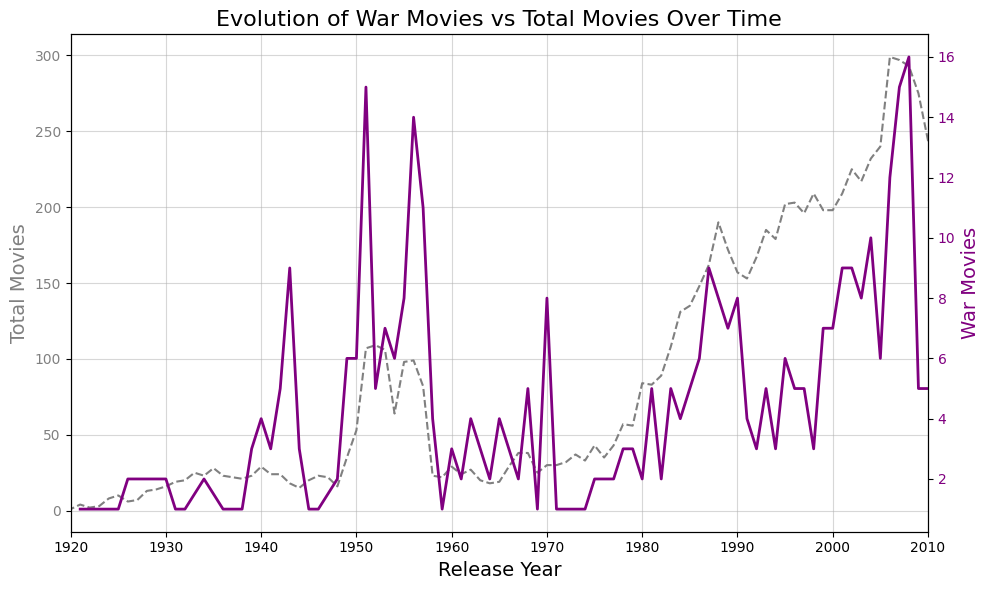

In [13]:
# Group by release year and count movies
war_movies_per_year = war_movies.groupby('Movie release year').size()


# Plot the number of War-related movies released over time
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total movies
ax1.plot(movies_per_year.index, movies_per_year.values, color='gray', linestyle='--', label='Total Movies')
ax1.set_xlabel('Release Year', fontsize=14)
ax1.set_ylabel('Total Movies', fontsize=14, color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Plot LGBT movies
ax2 = ax1.twinx()
ax2.plot(war_movies_per_year.index, war_movies_per_year.values, color='purple', linewidth=2, label='LGBT Movies')
ax2.set_ylabel('War Movies', fontsize=14, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Evolution of War Movies vs Total Movies Over Time', fontsize=16)
ax1.set_xlim(1920, 2010)
ax1.grid(alpha=0.5)

plt.tight_layout()
#plt.savefig('visuals/NbWarMovies_ReleaseYear.png')
plt.show()

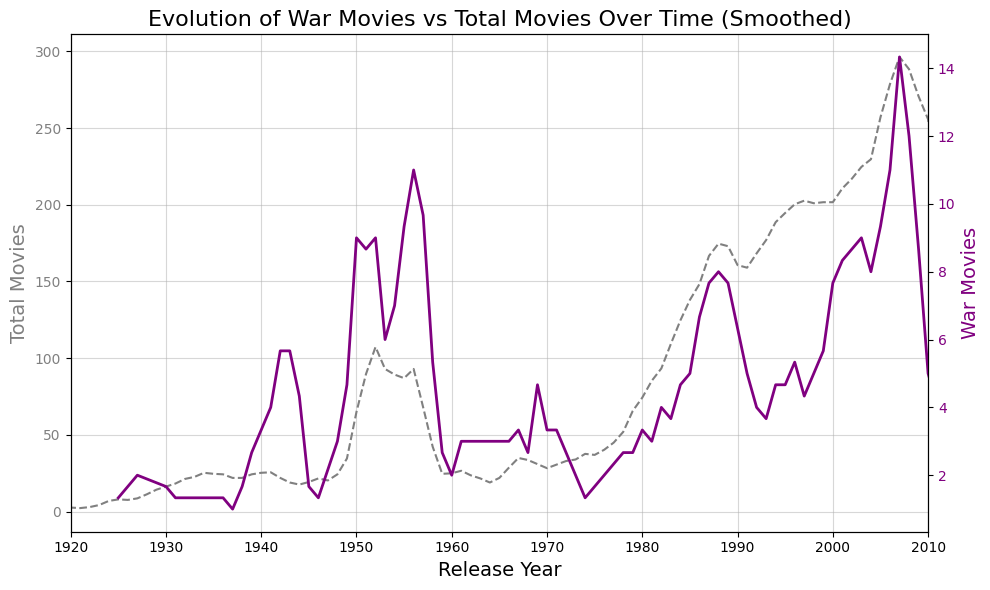

In [14]:
# Apply rolling average with a window of 3 years
war_movies_per_year_smooth = war_movies_per_year.rolling(window=3, center=True).mean()
movies_per_year_smooth = movies_per_year.rolling(window=3, center=True).mean()

# Plot the smoothed data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total movies (smoothed)
ax1.plot(movies_per_year_smooth.index, movies_per_year_smooth.values, color='gray', linestyle='--', label='Total Movies (Smoothed)')
ax1.set_xlabel('Release Year', fontsize=14)
ax1.set_ylabel('Total Movies', fontsize=14, color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Plot war movies (smoothed)
ax2 = ax1.twinx()
ax2.plot(war_movies_per_year_smooth.index, war_movies_per_year_smooth.values, color='purple', linewidth=2, label='War Movies (Smoothed)')
ax2.set_ylabel('War Movies', fontsize=14, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Add title and grid
plt.title('Evolution of War Movies vs Total Movies Over Time (Smoothed)', fontsize=16)
ax1.set_xlim(1920, 2010)
ax1.grid(alpha=0.5)

plt.tight_layout()
#plt.savefig('visuals/NbWarMovies_ReleaseYear_Smoothed.png')
plt.show()

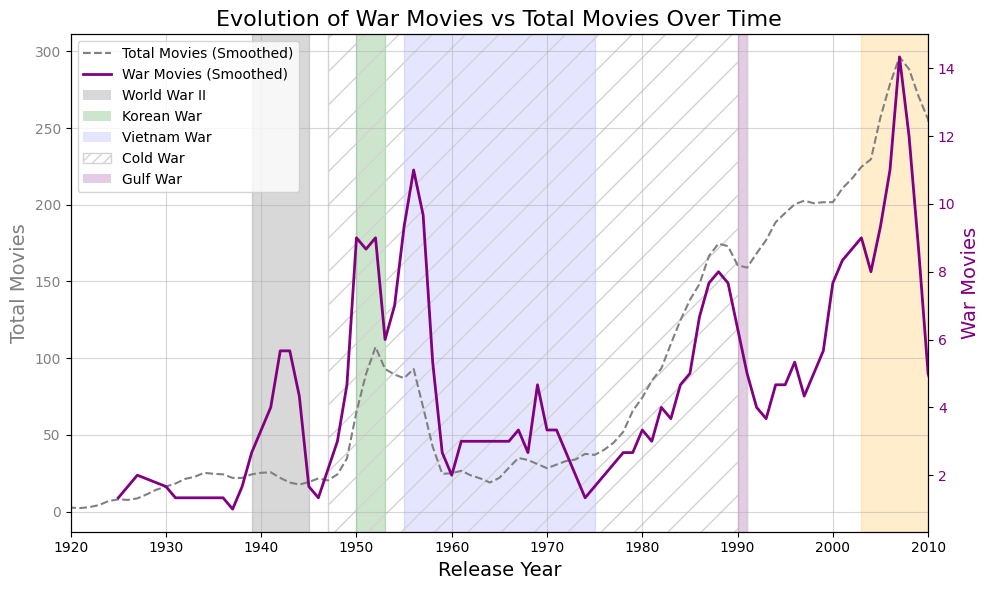

In [15]:
from matplotlib.patches import Patch

# Apply rolling average with a window of 3 years
war_movies_per_year_smooth = war_movies_per_year.rolling(window=3, center=True).mean()
movies_per_year_smooth = movies_per_year.rolling(window=3, center=True).mean()

# Plot the smoothed data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total movies (smoothed)
ax1.plot(movies_per_year_smooth.index, movies_per_year_smooth.values, color='gray', linestyle='--', label='Total Movies (Smoothed)')
ax1.set_xlabel('Release Year', fontsize=14)
ax1.set_ylabel('Total Movies', fontsize=14, color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Plot war movies (smoothed)
ax2 = ax1.twinx()
ax2.plot(war_movies_per_year_smooth.index, war_movies_per_year_smooth.values, color='purple', linewidth=2, label='War Movies (Smoothed)')
ax2.set_ylabel('War Movies', fontsize=14, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Annotate historical events
# WWII
ax1.axvspan(1939, 1945, color='gray', alpha=0.3, label='World War II')
ax1.text(1942, max(movies_per_year_smooth) * 0.9, 'WWII', color='black', fontsize=12)

# Korean War
ax1.axvspan(1950, 1953, color='green', alpha=0.2, label='Korean War')

# Vietnam War
ax1.axvspan(1955, 1975, color='blue', alpha=0.1, label='Vietnam War')

# Gulf War
ax1.axvspan(1990, 1991, color='purple', alpha=0.2, label='Gulf War')

# Iraq War
ax1.axvspan(2003, 2011, color='orange', alpha=0.2, label='Iraq War')

# Cold War (1947-1991) with Hatching Only
ax1.axvspan(1947, 1991, facecolor='none', hatch='/', edgecolor='lightgray', label='Cold War')
ax1.text(1960, max(movies_per_year_smooth) * 0.8, 'Cold War', color='black', fontsize=12)

# Add title and grid
plt.title('Evolution of War Movies vs Total Movies Over Time', fontsize=16)
ax1.set_xlim(1920, 2010)
ax1.grid(alpha=0.5)

# Add custom legend
legend_handles = [
    Line2D([0], [0], color='gray', linestyle='--', label='Total Movies (Smoothed)'),
    Line2D([0], [0], color='purple', linewidth=2, label='War Movies (Smoothed)'),
    Patch(facecolor='gray', alpha=0.3, label='World War II'),
    Patch(facecolor='green', alpha=0.2, label='Korean War'),
    Patch(facecolor='blue', alpha=0.1, label='Vietnam War'),
    Patch(facecolor='none', hatch='///', edgecolor='lightgray', label='Cold War'),
    Patch(facecolor='purple', alpha=0.2, label='Gulf War')
]
ax1.legend(handles=legend_handles, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()





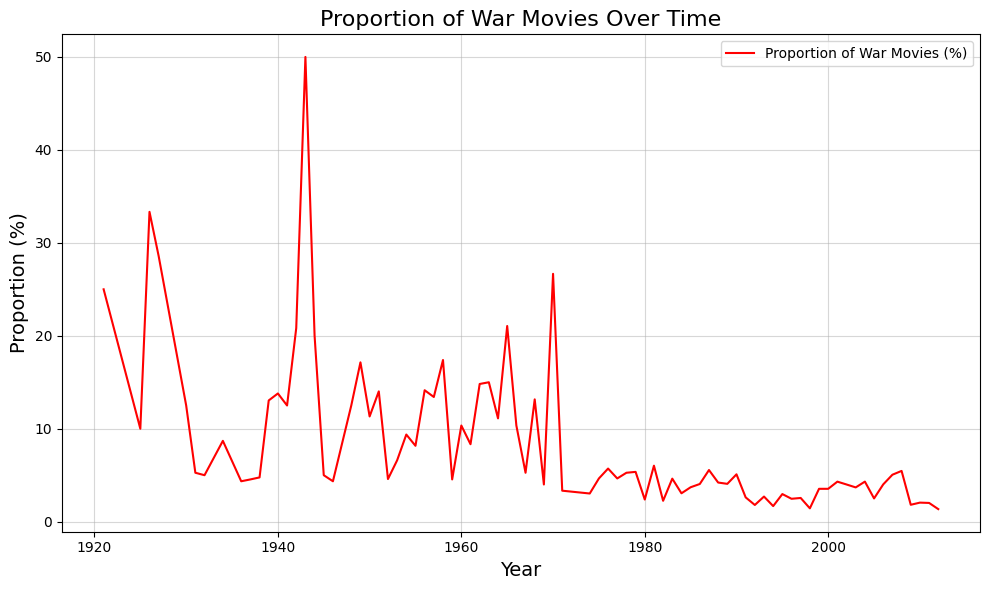

In [16]:
# Align indexes
aligned_index = war_movies_per_year.index.intersection(movies_per_year.index)
war_movies_per_year = war_movies_per_year.loc[aligned_index]
movies_per_year = movies_per_year.loc[aligned_index]

# Compute the proportion
war_movies_perc = (war_movies_per_year / movies_per_year) * 100

# Plot the proportion
plt.figure(figsize=(10, 6))
plt.plot(war_movies_per_year.index, war_movies_perc, label='Proportion of War Movies (%)', color='red')
plt.title("Proportion of War Movies Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Proportion (%)", fontsize=14)
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Calculate Pearson correlation
corr, p_value = pearsonr(war_movies_per_year, movies_per_year)
print(f"Pearson Correlation: {corr:.2f}, P-Value: {p_value:.4f}")

Pearson Correlation: 0.62, P-Value: 0.0000


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     49.74
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           5.62e-10
Time:                        13:17:54   Log-Likelihood:                -199.99
No. Observations:                  82   AIC:                             404.0
Df Residuals:                      80   BIC:                             408.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2952      0.468      4.904      0.0

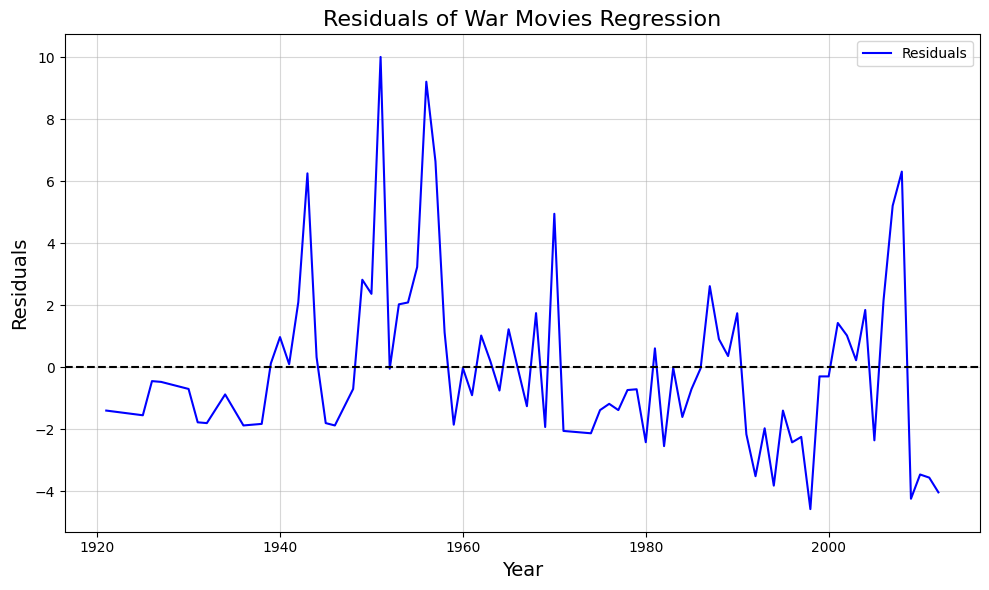

In [19]:
# Prepare data for regression
X = sm.add_constant(movies_per_year)  # Add constant for intercept
y = war_movies_per_year

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print summary of the model
print(model.summary())

# Compute residuals
residuals = y - model.predict(X)

# Plot residuals over time
plt.figure(figsize=(10, 6))
plt.plot(war_movies_per_year.index, residuals, label='Residuals', color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals of War Movies Regression", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


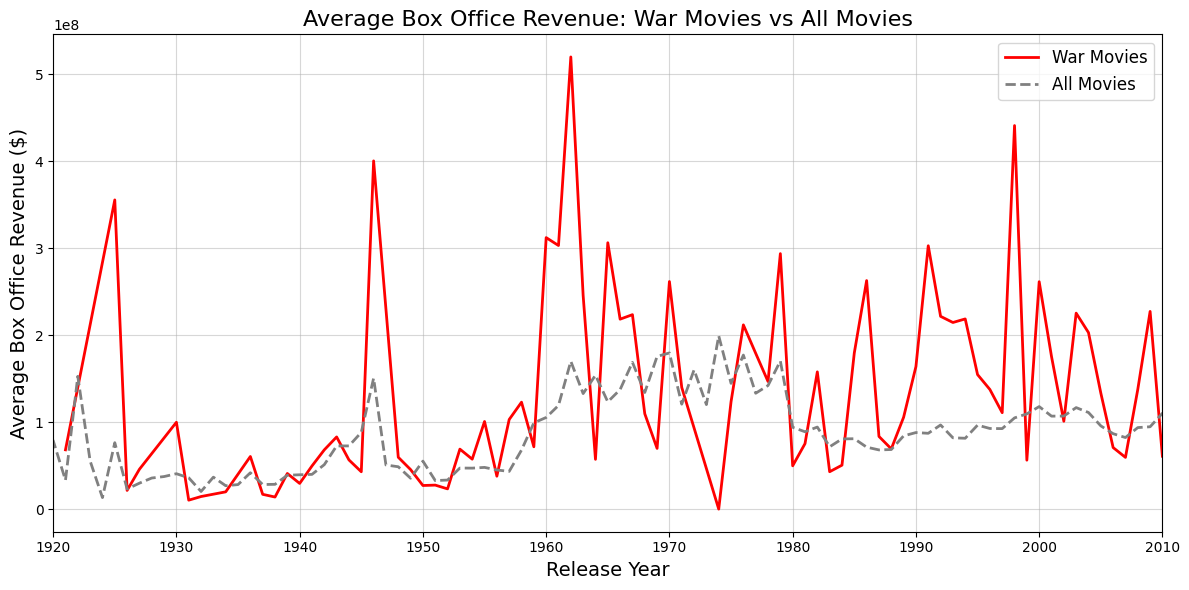

In [20]:
# Group by year and calculate average box office revenue for war movies
war_movies_box_office_per_year = war_movies.groupby('Movie release year')['Movie box office revenue'].mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(war_movies_box_office_per_year.index, war_movies_box_office_per_year.values, label='War Movies', color='red', linewidth=2)
plt.plot(box_office_per_year.index, box_office_per_year.values, label='All Movies', color='gray', linestyle='--', linewidth=2)
plt.title('Average Box Office Revenue: War Movies vs All Movies', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Box Office Revenue ($)', fontsize=14)
plt.xlim(1920, 2010)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


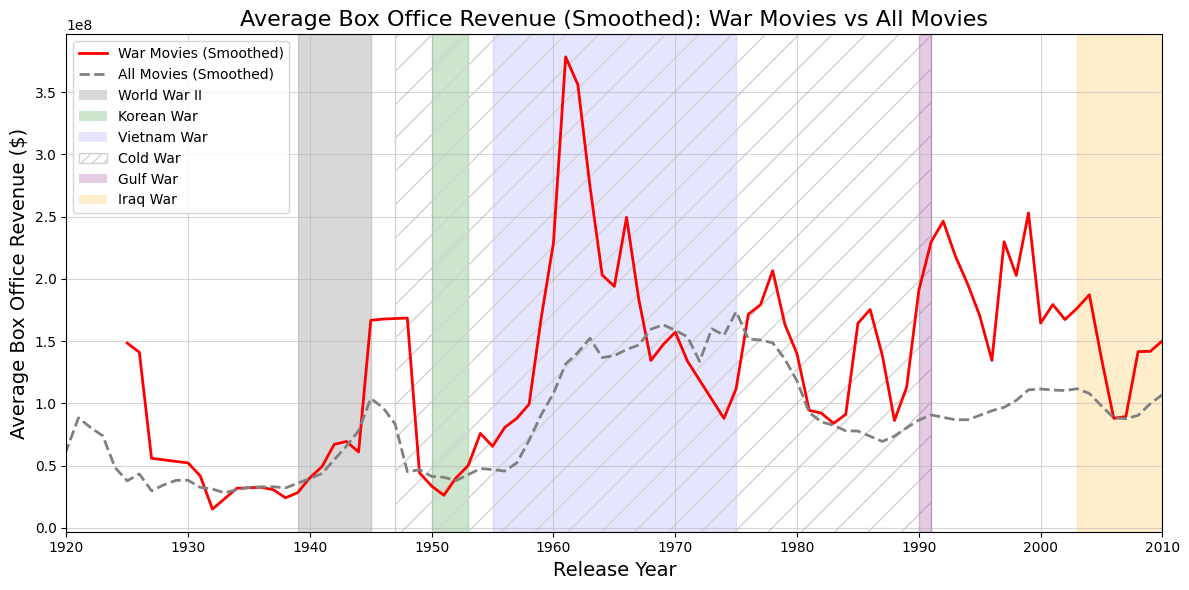

In [21]:
# Apply rolling average with a window of 3 years
war_movies_box_office_smooth = war_movies_box_office_per_year.rolling(window=3, center=True).mean()
box_office_smooth = box_office_per_year.rolling(window=3, center=True).mean()

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(war_movies_box_office_smooth.index, war_movies_box_office_smooth.values, label='War Movies (Smoothed)', color='red', linewidth=2)
plt.plot(box_office_smooth.index, box_office_smooth.values, label='All Movies (Smoothed)', color='gray', linestyle='--', linewidth=2)

# Annotate historical events
plt.axvspan(1939, 1945, color='gray', alpha=0.3, label='World War II')
plt.text(1942, max(box_office_smooth) * 0.9, 'WWII', color='black', fontsize=12)

plt.axvspan(1950, 1953, color='green', alpha=0.2, label='Korean War')
plt.text(1951, max(box_office_smooth) * 0.8, 'Korean War', color='black', fontsize=12)

plt.axvspan(1955, 1975, color='blue', alpha=0.1, label='Vietnam War')
plt.text(1965, max(box_office_smooth) * 0.7, 'Vietnam War', color='black', fontsize=12)

plt.axvspan(1947, 1991, facecolor='none', hatch='/', edgecolor='lightgray', label='Cold War')
plt.text(1960, max(box_office_smooth) * 0.6, 'Cold War', color='lightgray', fontsize=12)

plt.axvspan(1990, 1991, color='purple', alpha=0.2, label='Gulf War')
plt.text(1990.5, max(box_office_smooth) * 0.5, 'Gulf War', color='black', fontsize=12)

plt.axvspan(2003, 2011, color='orange', alpha=0.2, label='Iraq War')
plt.text(2007, max(box_office_smooth) * 0.4, 'Iraq War', color='black', fontsize=12)

# Add title, labels, and grid
plt.title('Average Box Office Revenue (Smoothed): War Movies vs All Movies', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Box Office Revenue ($)', fontsize=14)
plt.xlim(1920, 2010)
plt.grid(alpha=0.5)

# Add custom legend
legend_handles = [
    Line2D([0], [0], color='red', linewidth=2, label='War Movies (Smoothed)'),
    Line2D([0], [0], color='gray', linestyle='--', linewidth=2, label='All Movies (Smoothed)'),
    Patch(facecolor='gray', alpha=0.3, label='World War II'),
    Patch(facecolor='green', alpha=0.2, label='Korean War'),
    Patch(facecolor='blue', alpha=0.1, label='Vietnam War'),
    Patch(facecolor='none', hatch='///', edgecolor='lightgray', label='Cold War'),
    Patch(facecolor='purple', alpha=0.2, label='Gulf War'),
    Patch(facecolor='orange', alpha=0.2, label='Iraq War'),
]
plt.legend(handles=legend_handles, fontsize=10, loc='upper left')

plt.tight_layout()
plt.show()



**Superheros**


In [23]:
# List of genres related to LGBT themes
superhero_genres = [
    'Superhero', 'Superhero movie'
]

superhero_movies = df_3[df_3['Movie genres'].apply(lambda genres: any(g in genres for g in superhero_genres))]

In [24]:
# Identify overlapping movies
overlapping_movies = df_3[df_3['Movie genres'].apply(lambda genres: 
    any(g in genres for g in superhero_genres) and any(g in genres for g in war_genres))]

overlapping_movies

Unnamed: 0 Movie name  Movie release year  \
Wikipedia movie ID                                              
5676692                  46612   Iron Man                2008   

                    Movie box office revenue             Movie countries  \
Wikipedia movie ID                                                         
5676692                         8.586565e+08  [United States of America]   

                                                         Movie genres  \
Wikipedia movie ID                                                      
5676692             [Thriller, Science Fiction, Superhero movie, A...   

                                                              Summary  \
Wikipedia movie ID                                                      
5676692             Playboy and genius Tony Stark, who has inherit...   

                   Sentiment  vote_average        budget  decade  \
Wikipedia movie ID                                                 
5676692             negative          7.64  2.054293e+08  2000.0   

                   Corrected_Theme  War Related  
Wikipedia movie ID                               
5676692                 redemption         True

In [25]:
# Remove the movie from war_movies
war_movies = war_movies.drop(index=5676692, errors='ignore')

In [26]:
# Group by release year and count movies
superhero_movies_per_year = superhero_movies.groupby('Movie release year').size()
war_movies_per_year = war_movies.groupby('Movie release year').size()
total_movies_per_year = df_3.groupby('Movie release year').size()

# Normalize by total movies released each year
superhero_movies_norm = superhero_movies_per_year / total_movies_per_year
war_movies_norm = war_movies_per_year / total_movies_per_year


In [27]:
# Smooth data using rolling average
superhero_movies_smooth = superhero_movies_norm.rolling(window=3, center=True).mean()
war_movies_smooth = war_movies_norm.rolling(window=3, center=True).mean()



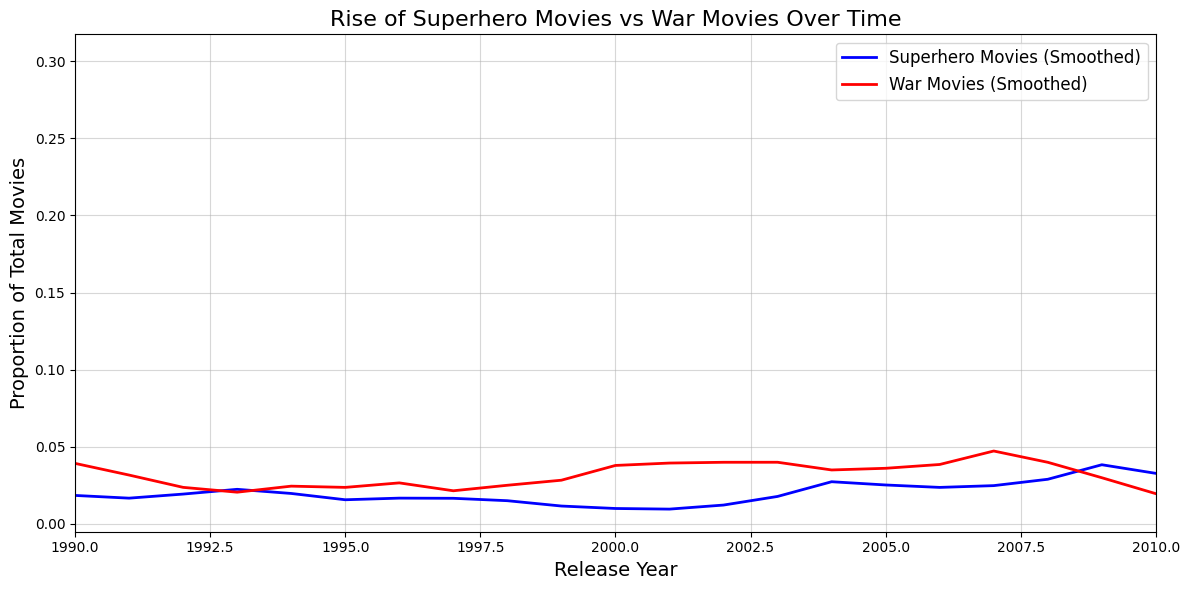

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(superhero_movies_smooth.index, superhero_movies_smooth.values, label='Superhero Movies (Smoothed)', color='blue', linewidth=2)
plt.plot(war_movies_smooth.index, war_movies_smooth.values, label='War Movies (Smoothed)', color='red', linewidth=2)

# Add title, labels, and grid
plt.title('Rise of Superhero Movies vs War Movies Over Time', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Proportion of Total Movies', fontsize=14)
plt.xlim(1990, 2010)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [29]:
# Align data for correlation analysis
aligned_data = pd.DataFrame({
    'superhero': superhero_movies_smooth,
    'war': war_movies_smooth
}).dropna()

# Correlation test
corr, p_value = pearsonr(aligned_data['superhero'], aligned_data['war'])

print(f"Correlation between superhero and war movies trends: {corr:.2f}")
print(f"P-value: {p_value:.4f}")

Correlation between superhero and war movies trends: -0.15
P-value: 0.5013


No Evidence of Audience Cannibalization:

    The weak correlation and high p-value suggest that the rise of superhero movies does not explain any decline (or change) in the trend of war movies.

In [30]:
# Group by release year and calculate average box office revenue
superhero_box_office = superhero_movies.groupby('Movie release year')['Movie box office revenue'].mean()
war_box_office = war_movies.groupby('Movie release year')['Movie box office revenue'].mean()

# Print first few values for verification
print("Superhero Movies Box Office (First 5 Years):")
print(superhero_box_office.head())

print("\nWar Movies Box Office (First 5 Years):")
print(war_box_office.head())


Superhero Movies Box Office (First 5 Years):
Movie release year
1966    3.765439e+07
1980    1.296739e+08
1981    3.992935e+08
1983    2.392162e+08
1985    2.343999e+06
Name: Movie box office revenue, dtype: float64

War Movies Box Office (First 5 Years):
Movie release year
1921    6.830297e+07
1925    3.553817e+08
1926    2.169078e+07
1927    4.600422e+07
1930    9.998662e+07
Name: Movie box office revenue, dtype: float64


In [31]:
# Apply rolling average
superhero_box_office_smooth = superhero_box_office.rolling(window=3, center=True).mean()
war_box_office_smooth = war_box_office.rolling(window=3, center=True).mean()


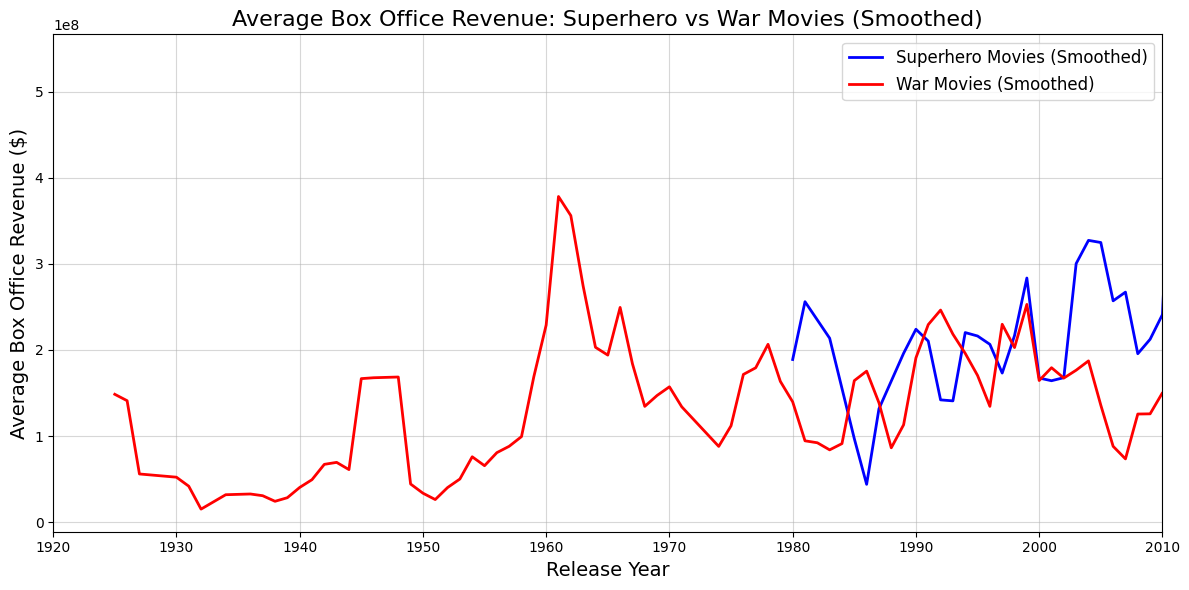

In [32]:
# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(superhero_box_office_smooth.index, superhero_box_office_smooth.values, label='Superhero Movies (Smoothed)', color='blue', linewidth=2)
plt.plot(war_box_office_smooth.index, war_box_office_smooth.values, label='War Movies (Smoothed)', color='red', linewidth=2)

# Add title, labels, and legend
plt.title('Average Box Office Revenue: Superhero vs War Movies (Smoothed)', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Box Office Revenue ($)', fontsize=14)
plt.xlim(1920, 2010)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [33]:
# Align data for comparison
aligned_data = pd.DataFrame({
    'superhero': superhero_box_office,
    'war': war_box_office
}).dropna()

# Perform t-test
t_stat, p_value = ttest_ind(aligned_data['superhero'], aligned_data['war'], equal_var=False)

# Print results
print(f"T-Statistic: {t_stat:.2f}")
print(f"P-Value: {p_value:.4f}")

T-Statistic: 1.81
P-Value: 0.0769


In [34]:
#Let's limit the period to 1980-2010
start_year = 1980
end_year = 2010

# Filter the main DataFrame
df_filtered = df_3[(df_3['Movie release year'] >= start_year) & (df_3['Movie release year'] <= end_year)]

# Filter war movies
war_movies_filtered = war_movies[(war_movies['Movie release year'] >= start_year) & (war_movies['Movie release year'] <= end_year)]

# Filter superhero movies
superhero_movies_filtered = superhero_movies[(superhero_movies['Movie release year'] >= start_year) & (superhero_movies['Movie release year'] <= end_year)]

In [35]:
# Group by release year and count movies
superhero_movies_per_year = superhero_movies_filtered.groupby('Movie release year').size()
war_movies_per_year = war_movies_filtered.groupby('Movie release year').size()
total_movies_per_year = df_filtered.groupby('Movie release year').size()

# Normalize by total movies released each year
superhero_movies_norm = superhero_movies_per_year / total_movies_per_year
war_movies_norm = war_movies_per_year / total_movies_per_year


# Group by release year and calculate average box office revenue
superhero_box_office = superhero_movies_filtered.groupby('Movie release year')['Movie box office revenue'].mean()
war_box_office = war_movies_filtered.groupby('Movie release year')['Movie box office revenue'].mean()

# Smooth data using rolling average
superhero_movies_smooth = superhero_movies_norm.rolling(window=3, center=True).mean()
war_movies_smooth = war_movies_norm.rolling(window=3, center=True).mean()

# Smooth data using rolling average
superhero_box_office_smooth = superhero_box_office.rolling(window=3, center=True).mean()
war_box_office_smooth = war_box_office.rolling(window=3, center=True).mean()


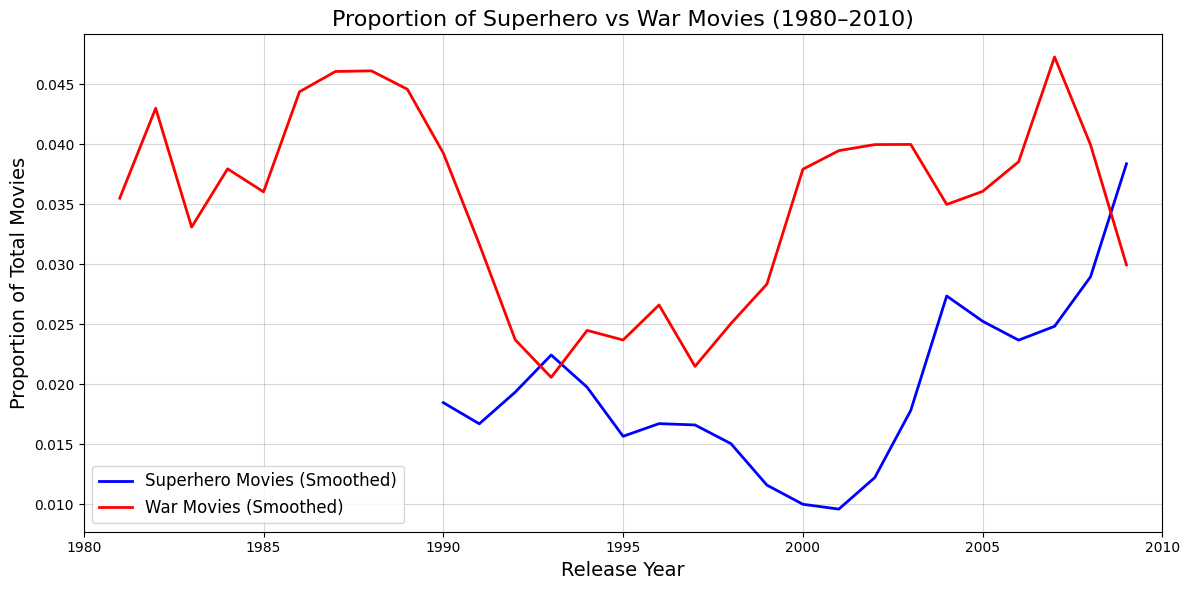

In [36]:
# Plot smoothed trends for counts
plt.figure(figsize=(12, 6))
plt.plot(superhero_movies_smooth.index, superhero_movies_smooth.values, label='Superhero Movies (Smoothed)', color='blue', linewidth=2)
plt.plot(war_movies_smooth.index, war_movies_smooth.values, label='War Movies (Smoothed)', color='red', linewidth=2)

# Add title and labels
plt.title('Proportion of Superhero vs War Movies (1980–2010)', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Proportion of Total Movies', fontsize=14)
plt.xlim(start_year, end_year)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

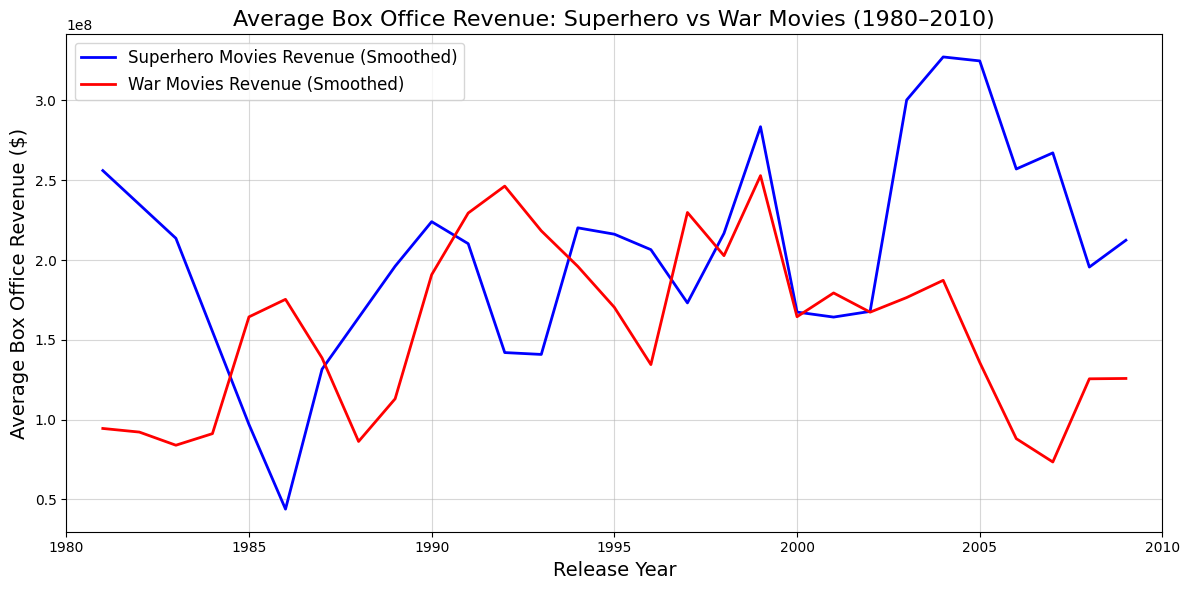

In [39]:
# Plot smoothed trends for box office revenue
plt.figure(figsize=(12, 6))
plt.plot(superhero_box_office_smooth.index, superhero_box_office_smooth.values, label='Superhero Movies Revenue (Smoothed)', color='blue', linewidth=2)
plt.plot(war_box_office_smooth.index, war_box_office_smooth.values, label='War Movies Revenue (Smoothed)', color='red', linewidth=2)

# Add title and labels
plt.title('Average Box Office Revenue: Superhero vs War Movies (1980–2010)', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Box Office Revenue ($)', fontsize=14)
plt.xlim(start_year, end_year)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


In [40]:
# Align data for correlation analysis
aligned_counts = pd.DataFrame({
    'superhero': superhero_movies_smooth,
    'war': war_movies_smooth
}).dropna()

# Correlation test
corr_counts, p_value_counts = pearsonr(aligned_counts['superhero'], aligned_counts['war'])

print(f"Correlation between superhero and war movies proportions (1980–2010): {corr_counts:.2f}")
print(f"P-value: {p_value_counts:.4f}")

Correlation between superhero and war movies proportions (1980–2010): 0.04
P-value: 0.8795


In [41]:
# Drop NaN values
superhero_revenue = superhero_box_office.dropna()
war_revenue = war_box_office.dropna()

# Perform t-test
t_stat, p_value = ttest_ind(superhero_revenue, war_revenue, equal_var=False)

# Print results
print(f"T-Statistic (1980–2010): {t_stat:.2f}")
print(f"P-Value: {p_value:.4f}")

T-Statistic (1980–2010): 1.88
P-Value: 0.0668


**Theme analysis**

In [42]:
# Explode the themes for each movie
war_movies_exploded = war_movies.copy()
war_movies_exploded['Corrected_Theme'] = war_movies_exploded['Corrected_Theme'].str.split(',')
war_movies_exploded = war_movies_exploded.explode('Corrected_Theme').dropna(subset=['Corrected_Theme'])
war_movies_exploded['Corrected_Theme'] = war_movies_exploded['Corrected_Theme'].str.strip()

superhero_movies_exploded = superhero_movies.copy()
superhero_movies_exploded['Corrected_Theme'] = superhero_movies_exploded['Corrected_Theme'].str.split(',')
superhero_movies_exploded = superhero_movies_exploded.explode('Corrected_Theme').dropna(subset=['Corrected_Theme'])
superhero_movies_exploded['Corrected_Theme'] = superhero_movies_exploded['Corrected_Theme'].str.strip()


In [43]:
# Add decade column
war_movies_exploded['Decade'] = (war_movies_exploded['Movie release year'] // 10) * 10
superhero_movies_exploded['Decade'] = (superhero_movies_exploded['Movie release year'] // 10) * 10

# Count themes per decade
war_themes_per_decade = war_movies_exploded.groupby(['Decade', 'Corrected_Theme']).size().unstack(fill_value=0)
superhero_themes_per_decade = superhero_movies_exploded.groupby(['Decade', 'Corrected_Theme']).size().unstack(fill_value=0)


In [44]:
# Normalize theme frequencies
war_themes_normalized = war_themes_per_decade.div(war_themes_per_decade.sum(axis=1), axis=0)
superhero_themes_normalized = superhero_themes_per_decade.div(superhero_themes_per_decade.sum(axis=1), axis=0)

# Calculate total frequency for each theme across all decades
total_war_theme_frequency = war_themes_normalized.sum(axis=0)

# Select the top 10 themes by total frequency
top_10_war_themes = total_war_theme_frequency.nlargest(10).index


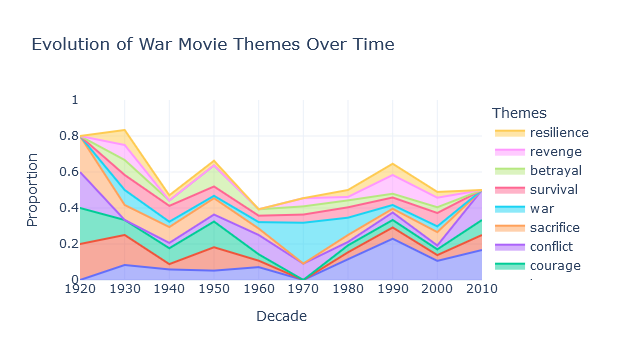

In [45]:
top_themes = war_themes_normalized.sum().nlargest(10).index
war_themes_normalized = war_themes_normalized[top_themes]
# Prepare data for Plotly
fig = go.Figure()

# Add each theme as a trace to the figure
for theme in war_themes_normalized.columns:
    fig.add_trace(
        go.Scatter(
            x=war_themes_normalized.index,
            y=war_themes_normalized[theme],
            mode='lines',
            stackgroup='one',  # Stacked area chart
            name=theme
        )
    )

# Customize layout
fig.update_layout(
    title="Evolution of War Movie Themes Over Time",
    xaxis_title="Decade",
    yaxis_title="Proportion of Themes",
    legend_title="Themes",
    hovermode="x unified",
    template="plotly_white",
    showlegend=True,
    xaxis=dict(
        tickmode='linear',
        dtick=10  # Ensure proper spacing for decades
    ),
    yaxis=dict(
        title="Proportion",
        range=[0, 1]
    )
)

# Show the interactive plot
fig.show()

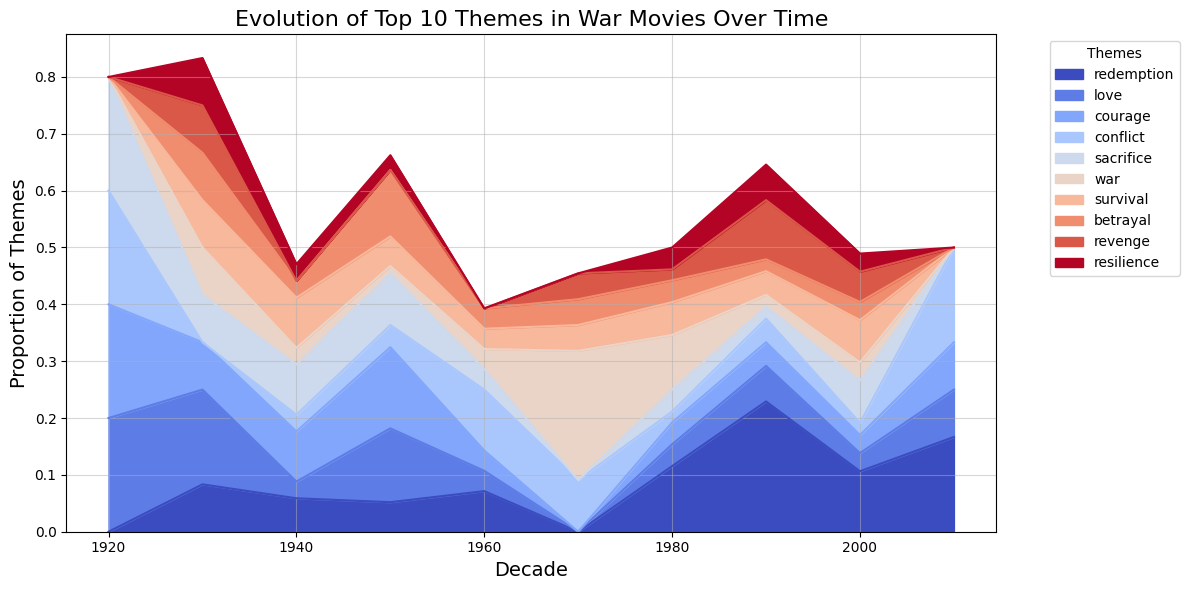

In [46]:
# Plot stacked area chart for war movies
war_themes_normalized_top10 = war_themes_normalized[war_themes_normalized.columns[:10]]  # Top 10 themes
# Filter war themes for the top 10
war_themes_normalized_top10 = war_themes_normalized[top_10_war_themes]

war_themes_normalized_top10.plot(kind='area', stacked=True, figsize=(12, 6), colormap='coolwarm')

plt.title('Evolution of Top 10 Themes in War Movies Over Time', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Proportion of Themes', fontsize=14)
plt.grid(alpha=0.5)
plt.legend(title='Themes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [47]:
# Identify top themes per decade
def get_top_themes(df, n=3):
    return df.apply(lambda x: x.nlargest(n).index.tolist(), axis=1)

war_top_themes = get_top_themes(war_themes_per_decade, n=3)
superhero_top_themes = get_top_themes(superhero_themes_per_decade, n=3)

print("Top 3 War Themes by Decade:")
print(war_top_themes)

print("\nTop 3 Superhero Themes by Decade:")
print(superhero_top_themes)


Top 3 War Themes by Decade:
Decade
1920            [conflict, courage, love]
1930            [love, betrayal, bravery]
1940     [courage, resistance, sacrifice]
1950            [courage, love, betrayal]
1960        [conflict, power, redemption]
1970            [war, ambition, conflict]
1980          [redemption, war, survival]
1990          [redemption, revenge, love]
2000    [redemption, sacrifice, survival]
2010      [conflict, redemption, courage]
dtype: object

Top 3 Superhero Themes by Decade:
Decade
1960    [justice, acceptance, adventure]
1980      [redemption, heroism, revenge]
1990    [redemption, revenge, adventure]
2000     [redemption, identity, revenge]
2010    [redemption, heroism, adventure]
dtype: object


In [48]:
# Calculate total frequency for each theme across all decades
total_theme_frequency = war_themes_per_decade.sum(axis=0)

# Select the top 15 themes
top_15_themes = total_theme_frequency.nlargest(10).index

# Filter the heatmap data to include only these themes
filtered_heatmap_data = war_themes_per_decade[top_15_themes]

# Normalize theme frequencies for the heatmap
normalized_heatmap_data = filtered_heatmap_data.div(filtered_heatmap_data.sum(axis=1), axis=0)


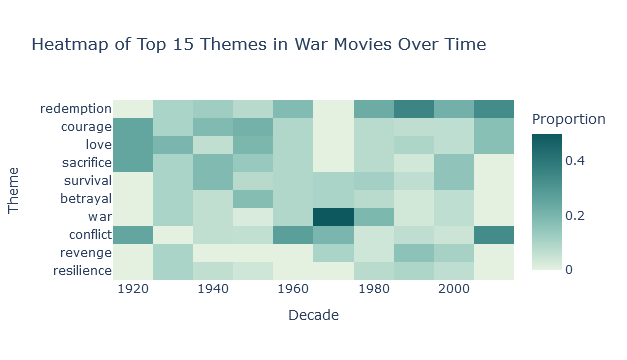

In [49]:
import plotly.express as px

# Convert data to long format for Plotly
heatmap_long = normalized_heatmap_data.reset_index().melt(id_vars='Decade', var_name='Theme', value_name='Proportion')

# Create interactive heatmap
fig = px.imshow(
    normalized_heatmap_data.T,
    labels={'x': 'Decade', 'y': 'Theme', 'color': 'Proportion'},
    title='Heatmap of Top 15 Themes in War Movies Over Time',
    color_continuous_scale='mint'
)

# Show the heatmap
fig.show()


In [50]:
# Compute total frequency of themes for superhero movies
superhero_theme_counts = superhero_themes_per_decade.sum(axis=0)
top_10_superhero_themes = superhero_theme_counts.nlargest(10)

# Compute total frequency of themes for war movies
war_theme_counts = war_themes_per_decade.sum(axis=0)
top_10_war_themes = war_theme_counts.nlargest(10)


In [51]:
# Combine top themes for both categories
comparison_df = pd.DataFrame({
    'Superhero Movies': top_10_superhero_themes,
    'War Movies': top_10_war_themes
}).fillna(0)  # Fill missing values with 0


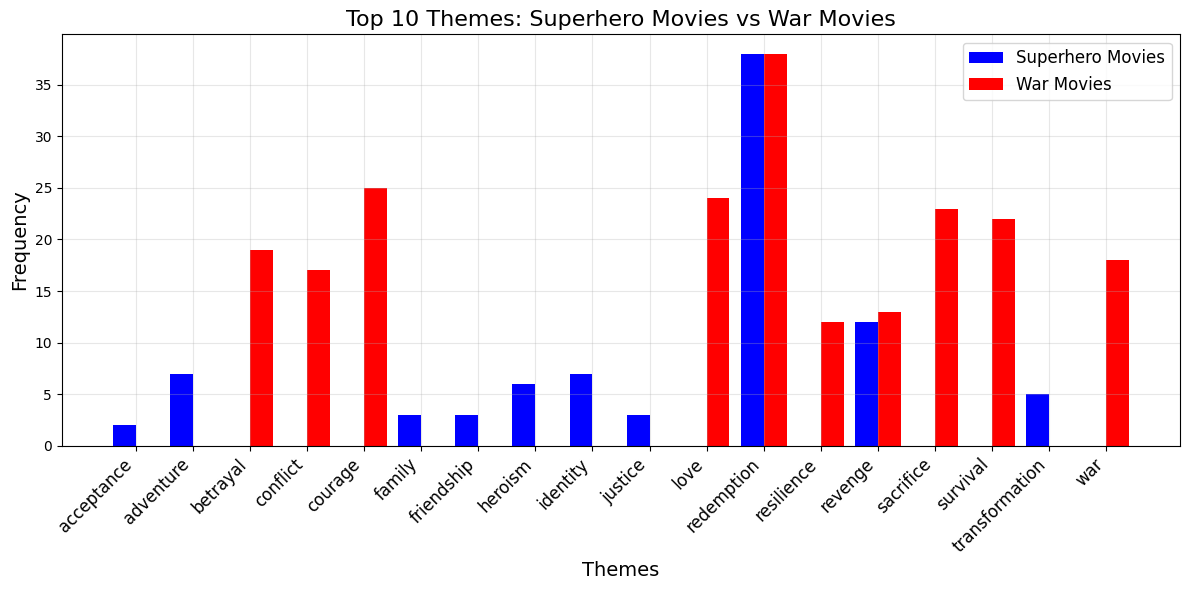

In [52]:
# Define bar positions
x = np.arange(len(comparison_df.index))  # Position for themes
width = 0.4  # Bar width

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Superhero movies bar
ax.bar(x - width/2, comparison_df['Superhero Movies'], width, label='Superhero Movies', color='blue')

# War movies bar
ax.bar(x + width/2, comparison_df['War Movies'], width, label='War Movies', color='red')

# Add labels, title, and legend
ax.set_title('Top 10 Themes: Superhero Movies vs War Movies', fontsize=16)
ax.set_xlabel('Themes', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [53]:
# Normalize the theme counts
normalized_comparison_df = pd.DataFrame({
    'Superhero Movies': top_10_superhero_themes / top_10_superhero_themes.sum(),
    'War Movies': top_10_war_themes / top_10_war_themes.sum()
}).fillna(0)  # Fill missing values with 0


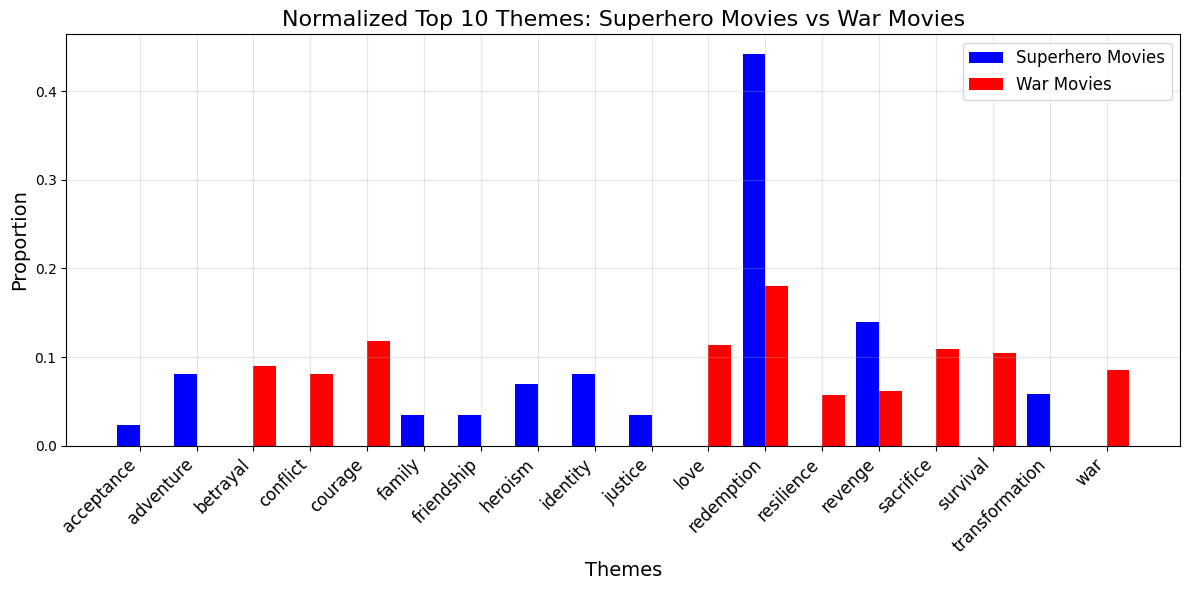

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Define bar positions
x = np.arange(len(normalized_comparison_df.index))  # Position for themes
width = 0.4  # Bar width

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Superhero movies bar
ax.bar(
    x - width/2,
    normalized_comparison_df['Superhero Movies'],
    width,
    label='Superhero Movies',
    color='blue'
)

# War movies bar
ax.bar(
    x + width/2,
    normalized_comparison_df['War Movies'],
    width,
    label='War Movies',
    color='red'
)

# Add labels, title, and legend
ax.set_title('Normalized Top 10 Themes: Superhero Movies vs War Movies', fontsize=16)
ax.set_xlabel('Themes', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(normalized_comparison_df.index, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


**Matched study**

In [ ]:
# Replace empty strings with 'Unknown' in 'Movie countries'
df_3['Movie countries'] = df_3['Movie countries'].apply(
    lambda x: ['Unknown country' if country == '' else country for country in x] if isinstance(x, list) else x
)

# Replace empty strings with 'Unknown' in 'Movie genres'
df_3['Movie genres'] = df_3['Movie genres'].apply(
    lambda x: ['Unknown genre' if genre == '' else genre for genre in x] if isinstance(x, list) else x
)


In [ ]:
# Drop rows with missing budget data
df_matching = df_3.dropna(subset=['budget']).copy()


# Verification: Check the number of remaining movies
print(f"Number of movies after dropping missing budgets: {len(df_matching)}")

In [ ]:
# One-hot encode 'Movie countries'
df_encoded_countries = pd.get_dummies(df_matching['Movie countries'].explode()).groupby(level=0).max()

# Add the encoded countries back to the dataset
df_matching = pd.concat([df_matching, df_encoded_countries], axis=1)

# One-hot encode 'Movie genres'
df_encoded_genres = pd.get_dummies(df_matching['Movie genres'].explode()).groupby(level=0).max()

# Add encoded genres back to the dataset
df_matching = pd.concat([df_matching, df_encoded_genres], axis=1)

In [ ]:
# Select matching variables
matching_vars = (
    ['Movie release year', 'Movie box office revenue', 'budget'] + 
    list(df_encoded_countries.columns) +  # Add country columns
    list(df_encoded_genres.columns)       # Add genre columns
)

# Create a dataset with only the matching variables and the target column
matching_data = df_matching[matching_vars + ['War Related']]

In [ ]:
# Compute weights
matching_data['weights'] = matching_data['War Related'] / matching_data['propensity_score'] + \
                           (1 - matching_data['War Related']) / (1 - matching_data['propensity_score'])

# Verification: Check summary statistics of weights
print("Weight Statistics:")
print(matching_data['weights'].describe())

In [ ]:
# Separate features (X) and target (y)
X = matching_data.drop(columns=['War Related'])
y = matching_data['War Related']

# Train logistic regression to compute propensity scores
logreg = LogisticRegression(max_iter=1000)
matching_data['propensity_score'] = logreg.fit(X, y).predict_proba(X)[:, 1]

# Verification: Check the range of propensity scores
print("Propensity Score Statistics:")
print(matching_data['propensity_score'].describe())

In [ ]:
# Weighted mean for war-related movies
treated_mean = (matching_data[matching_data['War Related'] == 1]['Movie box office revenue'] * 
                matching_data[matching_data['War Related'] == 1]['weights']).sum() / \
               matching_data[matching_data['War Related'] == 1]['weights'].sum()

# Weighted mean for non-war movies
control_mean = (matching_data[matching_data['War Related'] == 0]['Movie box office revenue'] * 
                matching_data[matching_data['War Related'] == 0]['weights']).sum() / \
               matching_data[matching_data['War Related'] == 0]['weights'].sum()

print(f"Weighted Mean Revenue (War Movies): {treated_mean}")
print(f"Weighted Mean Revenue (Non-War Movies): {control_mean}")

In [ ]:
# Split the data into war-related (treated) and non-war (control) movies
treated = matching_data[matching_data['War Related'] == 1]
control = matching_data[matching_data['War Related'] == 0]

# Perform nearest neighbor matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Get matched control samples
matched_control = control.iloc[indices.flatten()].reset_index()
matched_treated = treated.reset_index()

# Combine the matched pairs into one dataset
matched_data = pd.concat([matched_treated, matched_control], axis=1, ignore_index=False)

In [ ]:
# Verify data types
print(matching_data[['Movie box office revenue', 'War Related']].dtypes)

# Ensure numeric data
matching_data['Movie box office revenue'] = pd.to_numeric(matching_data['Movie box office revenue'], errors='coerce')
matching_data['War Related'] = pd.to_numeric(matching_data['War Related'], errors='coerce')


In [ ]:
# Prepare data for regression
X = sm.add_constant(matching_data['War Related'])  # Add constant for intercept
y = matching_data['Movie box office revenue']
weights = matching_data['weights']

# Fit weighted regression model
model = sm.WLS(y, X, weights=weights).fit()

# Print regression summary
print(model.summary())

In [ ]:
# Plot weighted density of box office revenue
sns.kdeplot(
    matching_data[matching_data['War Related'] == 1]['Movie box office revenue'], 
    weights=matching_data[matching_data['War Related'] == 1]['weights'], 
    label='War Movies', fill=True
)
sns.kdeplot(
    matching_data[matching_data['War Related'] == 0]['Movie box office revenue'], 
    weights=matching_data[matching_data['War Related'] == 0]['weights'], 
    label='Non-War Movies', fill=True
)
plt.title("Weighted Density of Box Office Revenue")
plt.xlabel("Box Office Revenue")
plt.ylabel("Density (Weighted)")
plt.legend()
plt.show()

In [ ]:
print(matched_data.columns)


In [ ]:
# Remove rows with NaN values in the revenue columns
matched_data_clean = matched_data.dropna(subset=['Movie box office revenue_x', 'Movie box office revenue_y'])

# Confirm the number of valid rows
print(f"Number of matched pairs after dropping NaN values: {len(matched_data_clean)}")


In [ ]:
# Compare box office revenue between matched pairs
t_stat, p_value = ttest_rel(
    matched_treated['Movie box office revenue'], 
    matched_control['Movie box office revenue']
)

print(f"T-Statistic: {t_stat:.2f}, P-Value: {p_value:.4f}")

# Interpret results
if p_value < 0.05:
    print("The difference in box office revenue is statistically significant.")
else:
    print("No statistically significant difference in box office revenue.")

In [ ]:
matched_treated['Movie box office revenue']


In [ ]:
matched_treated = matched_treated.merge(
    df_3[['Movie box office revenue']],
    left_index=True,
    right_index=True
)

matched_control = matched_control.merge(
    df_3[['Movie box office revenue']],
    left_index=True,
    right_index=True
)
